In [1]:
import uproot
import awkward as ak
import numpy as np
import sklearn.metrics as m
import boost_histogram as bh
import glob
import os
from scipy.interpolate import interp1d
import copy

from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec

from cycler import cycler
import mplhep as hep
# plt.style.use(hep.style.ROOT)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

def _p4_from_pxpypze(px, py, pz, energy):
    import vector
    vector.register_awkward()
    return vector.zip({'px': px, 'py': py, 'pz': pz, 'energy': energy})
def _p4_from_ptetaphie(pt, eta, phi, energy):
    import vector
    vector.register_awkward()
    return vector.zip({'pt': pt, 'eta': eta, 'phi': phi, 'energy': energy})
def _p4_from_ptetaphim(pt, eta, phi, mass):
    import vector
    vector.register_awkward()
    return vector.zip({'pt': pt, 'eta': eta, 'phi': phi, 'mass': mass})

from concurrent.futures import ThreadPoolExecutor
from functools import reduce
from operator import add

import random

In [2]:
def make_plot(H_dict, format, cut_name, stack_order=None):
    bins = np.arange(40, 201, 10)
    _, xedges, yedges = np.histogram2d([], [], bins=[bins, bins])

    process_labels = {
        'ggHH': r"$gg$F $HH\rightarrow 4b$",
        'ZH': "$ZH$",
        'ZZ': "$ZZ$",
        'QCD': "QCD",
        'TTbar': r'$t\bar{t}$',
        'ZJetsToQQ': r'$Z+\mathrm{jets}$' 
    }

    shrink_size = 0.8

    if format == '2d':
        first_row = ['ggHH', 'ZZ', 'ZH']
        second_row = [proc for proc in H_dict.keys() if proc not in first_row]
        
        fig, axes = plt.subplots(2, 3, figsize=(15, 9))
        
        x_start, x_end = 70, 170
        y_start, y_end = 70, 170
        
        bins = np.arange(40, 201, 10)
        _, xedges, yedges = np.histogram2d([], [], bins=[bins, bins])
        
        x_low_idx = np.where(xedges >= x_start)[0][0]
        x_high_idx = np.where(xedges <= x_end)[0][-1]
        y_low_idx = np.where(yedges >= y_start)[0][0]
        y_high_idx = np.where(yedges <= y_end)[0][-1]
        
        processed_H = {}
        for proc_name, H in H_dict.items():
            H_cropped = H[x_low_idx:x_high_idx, y_low_idx:y_high_idx]
            
            H_sum = np.sum(H_cropped)
            if H_sum > 0:
                H_norm = H_cropped / H_sum
            else:
                H_norm = H_cropped
            
            processed_H[proc_name] = H_norm
        
        xedges_cropped = xedges[x_low_idx:x_high_idx+1]
        yedges_cropped = yedges[y_low_idx:y_high_idx+1]
        
        if 'ZJetsToQQ' in processed_H:
            zjets_vmax = np.max(processed_H['ZJetsToQQ'])
        else:
            zjets_vmax = None
        
        for i, proc_name in enumerate(first_row):
            if proc_name in processed_H:
                ax = axes[0, i]
                H_norm = processed_H[proc_name]
                
                mesh = ax.pcolormesh(xedges_cropped, yedges_cropped, H_norm.T, 
                                    shading='flat', cmap='Reds', vmin=0)
                cbar = fig.colorbar(mesh, ax=ax, label='Normalized count', shrink=shrink_size)
                
                ax.set_xlim(x_start, x_end)
                ax.set_ylim(y_start, y_end)
                ax.set_xlabel(r'$m_{h_1} \mathrm{(GeV)}$', fontsize=15)
                ax.set_ylabel(r'$m_{h_2} \mathrm{(GeV)}$', fontsize=15)
                ax.set_title(process_labels[proc_name], fontsize=15)
                ax.set_aspect('equal', 'box')
            else:
                axes[0, i].set_visible(False)
        
        for i, proc_name in enumerate(second_row[:3]):  
            if proc_name in processed_H:
                ax = axes[1, i]
                H_norm = processed_H[proc_name]
                
                vmax = zjets_vmax if zjets_vmax is not None else np.max(H_norm)
                
                mesh = ax.pcolormesh(xedges_cropped, yedges_cropped, H_norm.T, 
                                    shading='flat', cmap='Reds', vmax=vmax, vmin=0)
                cbar = fig.colorbar(mesh, ax=ax, label='Normalized count', shrink=shrink_size)
                
                ax.set_xlim(x_start, x_end)
                ax.set_ylim(y_start, y_end)
                ax.set_xlabel(r'$m_{h_1} \mathrm{(GeV)}$', fontsize=15)
                ax.set_ylabel(r'$m_{h_2} \mathrm{(GeV)}$', fontsize=15)
                ax.set_title(process_labels[proc_name], fontsize=15)
                ax.set_aspect('equal', 'box')
            else:
                axes[1, i].set_visible(False)
        
        for i in range(len(second_row), 3):
            axes[1, i].set_visible(False)
        
        plt.tight_layout()

        plt.savefig(f"PLOTS/combined_{cut_name}.png", dpi=300, bbox_inches='tight')
        plt.savefig(f"PLOTS/combined_{cut_name}.pdf", dpi=300, bbox_inches='tight')
        plt.show()


def load_saved_histograms(hist_dir, cut_name):
    import os
    import pickle
    
    H_dict = {}
    bins = None
    xedges = None
    yedges = None
    
    if os.path.exists(hist_dir):
        cut_prefix = f"{cut_name}_"
        for filename in os.listdir(hist_dir):
            if filename.endswith('_hist.pkl') and filename.startswith(cut_prefix):
                proc_name = filename[len(cut_prefix):].replace('_hist.pkl', '')
                hist_file = os.path.join(hist_dir, filename)
                
                with open(hist_file, 'rb') as f:
                    data = pickle.load(f)
                    H_dict[proc_name] = data['histogram']
                    
                    # Set bins and edges from the first file
                    if bins is None:
                        bins = data['bins']
                        xedges = data['xedges']
                        yedges = data['yedges']
                
                print(f"Loaded histogram for {proc_name} from {hist_file}")
    
    return H_dict, bins, xedges, yedges



Processing ggHH...
Found 5 files for ggHH
  [5/5] Processing ensemble_method2_ggHH_id800-999.root
Total events collected: 1525928
Total weight: 722.17

ggHH: Sum = 722.17
Histogram sum by rows:
[  1.15784282   3.18247049   4.80931893   6.55424698  10.65508821
  21.53213771  54.13228733 148.27155817 208.89207202 126.25479711
  52.73307936  28.65335616  19.4220857   15.75333542  11.39456477
   8.77007372]

Processing QCD...
Found 557 files for QCD
  [557/557] Processing ensemble_method2_QCD_mergeid13.rootroot
Total events collected: 631656
Total weight: 4618218.64

QCD: Sum = 4618218.64
Histogram sum by rows:
[ 73120.18670068 176896.60206208 222983.30307875 249256.41485846
 267187.34755353 281159.21804498 294272.01225033 303038.24601236
 313544.56620923 326346.63069407 345304.7992887  362658.140268
 382709.34635006 403619.62871821 334304.96718279 281817.2339237 ]

Processing TTbar...
Found 120 files for TTbar
  [120/120] Processing ensemble_method2_TTbarEXT_0032.root
Total events collec

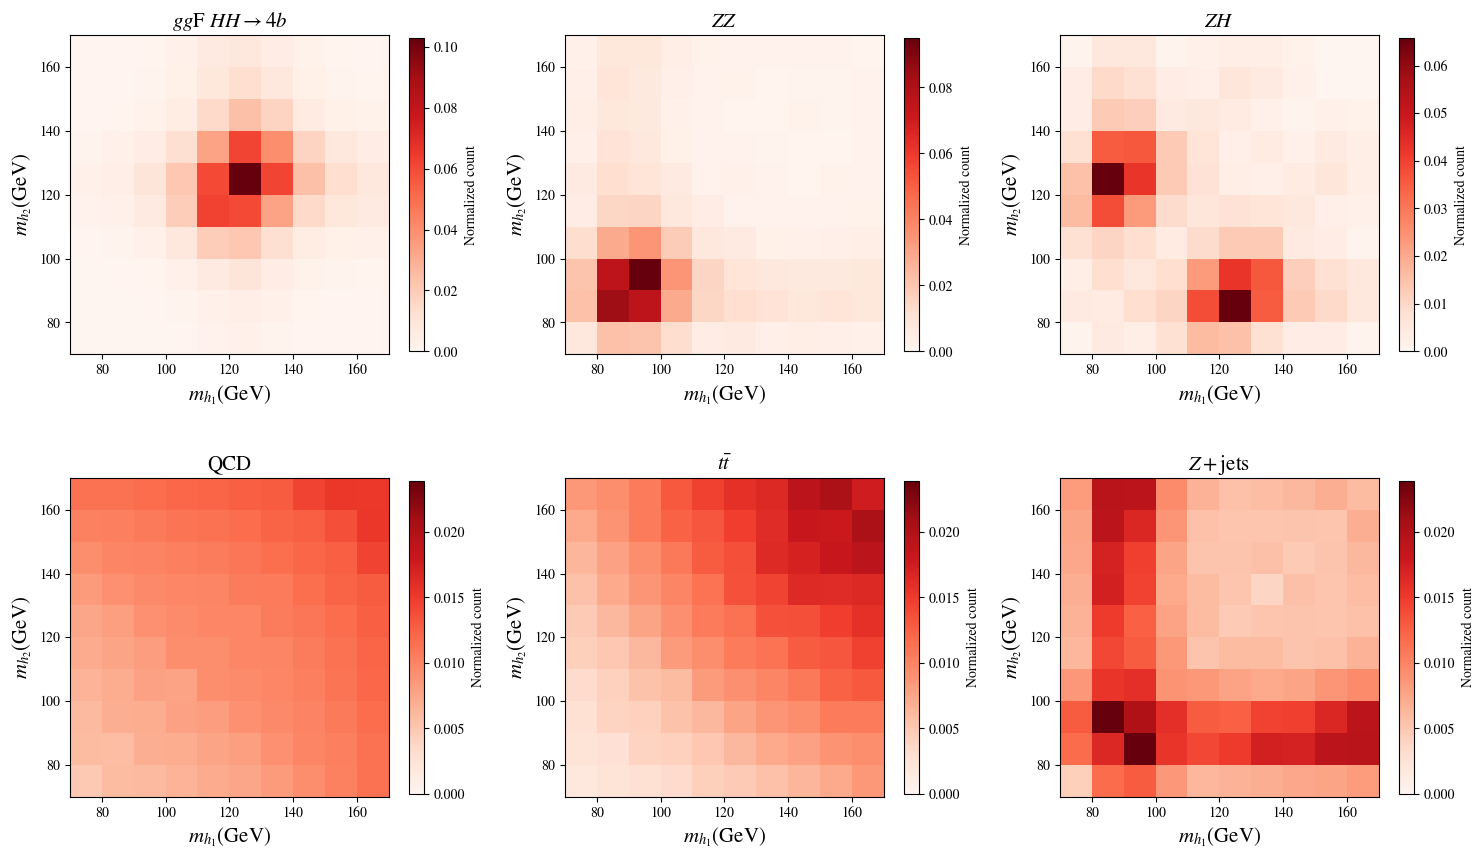

In [3]:
ntuple_base_dir = "/data/bond/tyyang99/HH4b/ensemble_method2_ntuples_cdfv2"

# Configuration
lumi_scale = 4.5  # 450 fb^-1

# Weight dictionary
weight_dict = {
    "QCD": lumi_scale * 4.5226e+06 * 1e5 / ((17600+38072) * 50e5),
    "ZJetsToQQ": lumi_scale * 1253.61 * 1e5 / (4000 * 1e5),
    "TTbar": lumi_scale * 83175900 / (40305472 + 120928855),
    "SingleTop": lumi_scale * 18487900 / 17032212,
    "TW": lumi_scale * 6496000 / 4694318,
    "TTbarW": lumi_scale * 74530 / 1000000,
    "TTbarZ": lumi_scale * 85900 / 1000000,
    "WW": lumi_scale * 11870000 / 14330905,
    "ZW": lumi_scale * 4674000 / 7117197,
    "ZZ": lumi_scale * 1691000 / 7055884,
    "SingleHiggs": lumi_scale * 4858000 / 10000000,
    "VBFH": lumi_scale * 378200 / 1000000,
    "WplusH": lumi_scale * 83990 / 499991,
    "WminusH": lumi_scale * 53270 / 499999,
    "ZH": lumi_scale * 76120 / 300000,
    "ttH": lumi_scale * 50710 / 300000,
    "ggHH": lumi_scale * 1051.7 / 10000000,
    "qqHH": lumi_scale * 58.5 / 3000000
}

cut_value = 0.9
cut_name = f"cut{str(cut_value).replace('.','p')}"

discriminant = 'score_hh4bvsboth'  

background_processes = ['QCD', 'TTbar', 'SingleTop', 'TW', 'TTbarW', 'TTbarZ', 'WW', 'ZW', 'ZZ', 'SingleHiggs', 'VBFH', 'WplusH', 'WminusH', 'ZH', 'ttH', 'ZJetsToQQ']
process_list = ['ggHH'] + ['QCD', 'TTbar', 'ZH', 'ZJetsToQQ', 'ZZ']


H_dict = {}
bins = np.arange(40, 210, 10)

for proc_name in process_list:
    
    print(f"\n{'='*80}")
    print(f"Processing {proc_name}...")
    print(f"{'='*80}")
    
    proc_dir = os.path.join(ntuple_base_dir, proc_name)
    
    if not os.path.exists(proc_dir):
        print(f"Warning: Directory not found for {proc_name}")
        H = np.zeros((len(bins)-1, len(bins)-1))
        H_dict[proc_name] = H
        continue
    
    all_x_means = []
    all_y_means = []
    all_weights = []
    
    weight = weight_dict[proc_name]
    
    ntuple_files = glob.glob(os.path.join(proc_dir, "ensemble_method2_*.root"))
    
    print(f"Found {len(ntuple_files)} files for {proc_name}")
    
    for f_id, ntuple_file in enumerate(ntuple_files):
        try:
            print(f"\r  [{f_id+1}/{len(ntuple_files)}] Processing {os.path.basename(ntuple_file)}", end='')
            
            with uproot.open(ntuple_file) as f:
                tree = f["tree"]
                data = tree.arrays([
                    f'model0_{discriminant}',
                    f'model1_{discriminant}',
                    f'model2_{discriminant}',
                    'combined_basic_fit_cut',
                    'ensemble_final_peak_x',
                    'ensemble_final_peak_y',
                    'ensemble_original_peak_x',
                    'ensemble_original_peak_y',
                    'weight'
                ])
            
            # Apply combined_basic_fit_cut
            cut_mask = data['combined_basic_fit_cut'] == 1
            
            if ak.sum(cut_mask) == 0:
                print(f"    No events pass combined_basic_fit_cut")
                continue
            
            # Get filtered data after basic_fit_cut
            scores_model0 = data[f'model0_{discriminant}'][cut_mask]
            scores_model1 = data[f'model1_{discriminant}'][cut_mask]
            scores_model2 = data[f'model2_{discriminant}'][cut_mask]
            
            # Calculate ensemble scores (average of three models)
            ensemble_scores = (scores_model0 + scores_model1 + scores_model2) / 3.0
            
            # Apply score cut
            score_cut = ensemble_scores > cut_value
            
            # print(f"    Rate for ensemble_score > {cut_value}: {ak.sum(score_cut)/len(ensemble_scores):.4f}")
            
            if ak.sum(score_cut) == 0:
                print(f"    No events pass score cut")
                continue
            
            peak_x = ak.to_numpy(data['ensemble_final_peak_x'][cut_mask][score_cut])
            peak_y = ak.to_numpy(data['ensemble_final_peak_y'][cut_mask][score_cut])
            # peak_x = ak.to_numpy(data['ensemble_original_peak_x'][cut_mask][score_cut])
            # peak_y = ak.to_numpy(data['ensemble_original_peak_y'][cut_mask][score_cut])
            event_weights = ak.to_numpy(data['weight'][cut_mask][score_cut])
            
            p1_cut = (peak_x >= 40) & (peak_x <= 200) & (peak_y >= 40) & (peak_y <= 200)
            
            peak_x = peak_x[p1_cut]
            peak_y = peak_y[p1_cut]
            event_weights = event_weights[p1_cut]
            
            # print(f"    Events after all cuts: {len(peak_x)}")
            
            if len(peak_x) > 0:
                all_x_means.append(peak_x)
                all_y_means.append(peak_y)
                all_weights.append(event_weights)
                
        except Exception as e:
            print(f"    Error processing {ntuple_file}: {e}")
            continue
    
    if all_x_means:
        x_means = np.concatenate(all_x_means)
        y_means = np.concatenate(all_y_means)
        weights = np.concatenate(all_weights)
        
        print(f"\nTotal events collected: {len(x_means)}")
        print(f"Total weight: {np.sum(weights):.2f}")
        
        H, xedges, yedges = np.histogram2d(
            x_means, y_means, 
            bins=[bins, bins], 
            weights=weights
        )
        
        H = (H + H.T) / 2
        H_dict[proc_name] = H
        
        print(f"\n{proc_name}: Sum = {np.sum(H):.2f}")
        print(f"Histogram sum by rows:")
        print(np.sum(H, axis=1))
        
    else:
        H = np.zeros((len(bins)-1, len(bins)-1))
        H_dict[proc_name] = H
        print(f"{proc_name}: no data")

make_plot(H_dict, '2d', cut_name)
